In [1]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Load dataset

In [2]:
import pandas as pd
from pandas import read_csv
df = pd.read_csv('total_sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
df.head()

,date,agent_id,sales
0,2021-09-05,ABC,90.3
1,2021-09-05,ABC,60.9
2,2021-09-05,ABC,42.0
3,2021-09-05,ABC,45.0
4,2021-09-05,ABC,493.0


In [3]:
# convert text date to python date

df['date'] = pd.to_datetime(df['date'])

In [4]:
# Set the date as index 
df = df.set_index('date')

# Select the proper time period for weekly aggreagation
df = df['2019-12-20':'2021-09-05'].resample('W').sum()
df

,sales
date,
2019-12-22,8402.925
2019-12-29,21445.350
2020-01-05,26204.950
2020-01-12,26738.525
2020-01-19,13394.300
...,...
2021-08-08,46352.650
2021-08-15,44140.965
2021-08-22,40253.375


# Visualize the Data

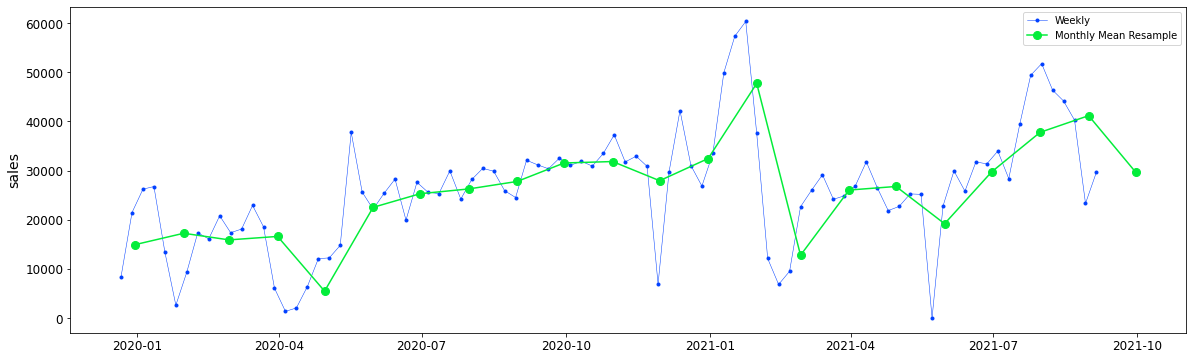

In [5]:
import warnings
import matplotlib.pyplot as plt

y = df['sales']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('sales')
ax.legend();

# Check for Stationarity

In [6]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

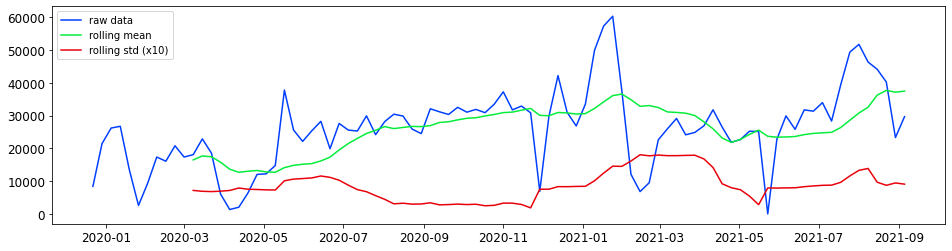

In [7]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

## Augmented Dickey-Fuller Test

In [8]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))


In [9]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -4.139
P-value = 0.001
Critical values :
	1%: -3.506944401824286 - The data is  stationary with 99% confidence
	5%: -2.894989819214876 - The data is  stationary with 95% confidence
	10%: -2.584614550619835 - The data is  stationary with 90% confidence


# Make the Data Stationary

## Detrending

 > Is the de-trended data stationary ?
Test statistic = -5.041
P-value = 0.000
Critical values :
	1%: -3.518281134660583 - The data is  stationary with 99% confidence
	5%: -2.899878185191432 - The data is  stationary with 95% confidence
	10%: -2.5872229937594873 - The data is  stationary with 90% confidence


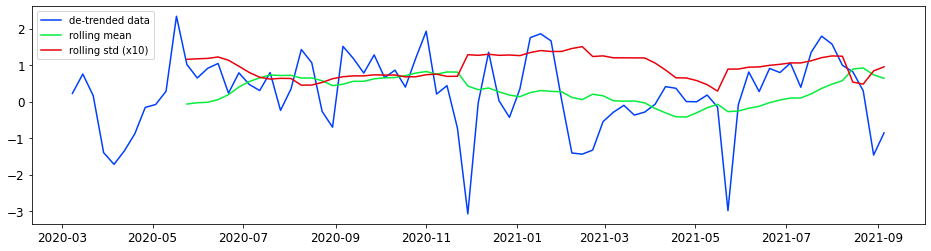

In [10]:

y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

## Differencing

 > Is the 12 lag differenced data stationary ?
Test statistic = -4.336
P-value = 0.000
Critical values :
	1%: -3.518281134660583 - The data is  stationary with 99% confidence
	5%: -2.899878185191432 - The data is  stationary with 95% confidence
	10%: -2.5872229937594873 - The data is  stationary with 90% confidence


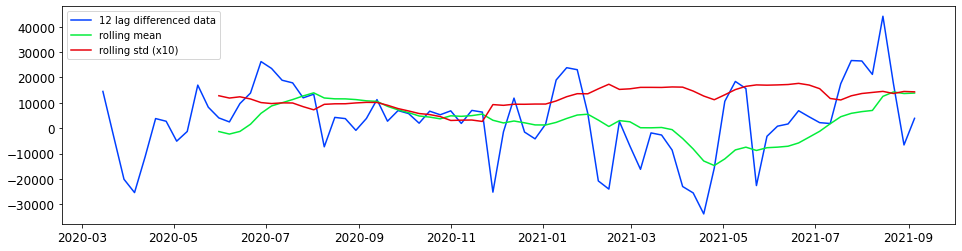

In [11]:

y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')


## Combining Detrending and Differencing

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -3.231
P-value = 0.018
Critical values :
	1%: -3.53692771987915 - The data is not stationary with 99% confidence
	5%: -2.907887369384766 - The data is  stationary with 95% confidence
	10%: -2.591493291015625 - The data is  stationary with 90% confidence


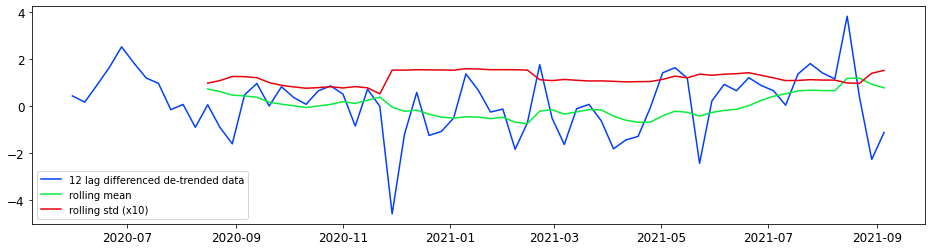

In [12]:
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

# Create Training & Testing Datasets

## Set the y_to_train, y_to_test, and the length of predict units

In [13]:
y_to_train = y[:'2021-04-19'] # dataset to train
y_to_val = y['2021-04-26':] # last X months for test  
predict_date = len(y) - len(y[:'2021-04-26']) # the number of data points for the test set

# Choosing a Time Series Prediction Model

### Simple Exponential Smoothing

In [14]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 12779.59
The Root Mean Squared Error of our forecasts with auto optimization is 13083.09


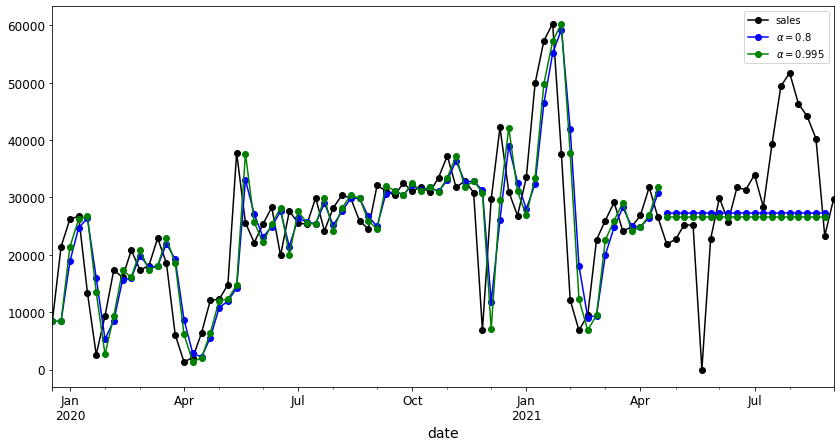

In [15]:
ses(y, y_to_train,y_to_val,0.8,predict_date)

## Holt’s Linear Trend Method

In [16]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()

The Root Mean Squared Error of Holts Linear trend 10788.28
The Root Mean Squared Error of Holts Exponential trend 15337.4


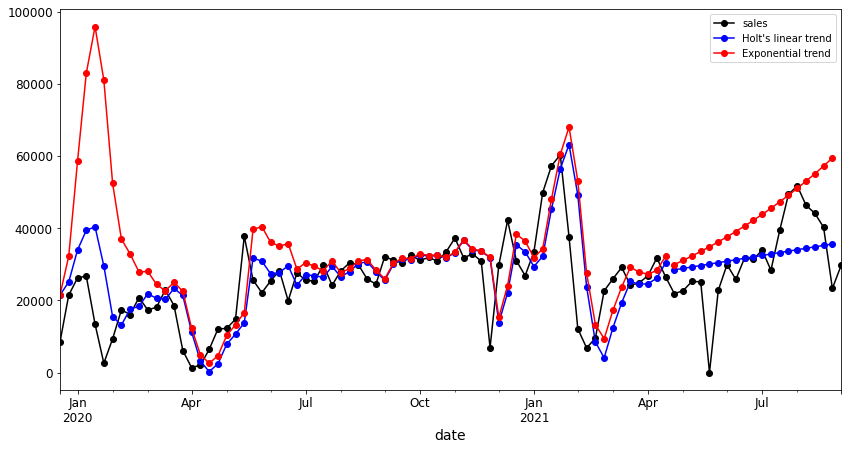

In [17]:
holt(y, y_to_train,y_to_val,0.6,0.2,predict_date)